In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import joblib

sns.set(style="whitegrid")

In [2]:
df = pd.read_csv("../data/churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Fix TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Target encoding
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


C:\Users\Asus\AppData\Local\Temp\ipykernel_2348\701715257.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [6]:
# Tenure buckets
df['tenure_bucket'] = pd.cut(
    df['tenure'],
    bins=[0, 12, 24, 48, 72],
    labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr']
)

# Charges normalized by tenure
df['charges_per_month'] = df['TotalCharges'] / (df['tenure'] + 1)

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bucket,charges_per_month
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-1yr,14.925000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,0,2-4yr,53.985714
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-1yr,36.050000
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,2-4yr,40.016304
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-1yr,50.550000


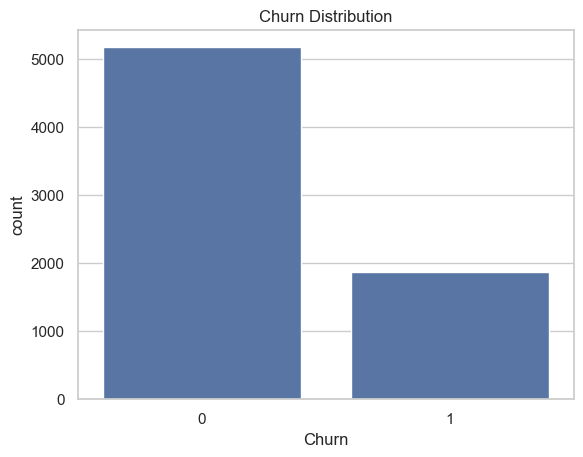

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [7]:
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

print(df['Churn'].value_counts(normalize=True))


In [9]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_bucket,charges_per_month
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0-1yr,14.925000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,2-4yr,53.985714
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0-1yr,36.050000
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,2-4yr,40.016304
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0-1yr,50.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,1-2yr,79.620000
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,4-6yr,100.861644
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0-1yr,28.870833
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,0-1yr,61.320000


In [10]:
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


In [11]:
pipelines = {
    "LogisticRegression": (
        Pipeline([
            ('prep', preprocessor),
            ('model', LogisticRegression(
                max_iter=1000,
                class_weight='balanced'
            ))
        ]),
        {
            'model__C': [0.01, 0.1, 1, 10]
        }
    ),

    "DecisionTree": (
        Pipeline([
            ('prep', preprocessor),
            ('model', DecisionTreeClassifier(
                class_weight='balanced',
                random_state=42
            ))
        ]),
        {
            'model__max_depth': [5, 10, None],
            'model__min_samples_split': [2, 10, 20]
        }
    ),

    "RandomForest": (
        Pipeline([
            ('prep', preprocessor),
            ('model', RandomForestClassifier(
                class_weight='balanced',
                random_state=42,
                n_jobs=-1
            ))
        ]),
        {
            'model__n_estimators': [300, 500],
            'model__max_depth': [10, 15, None],
            'model__min_samples_leaf': [1, 2],
            'model__max_features': ['sqrt', 'log2']
        }
    ),

    "XGBoost": (
        Pipeline([
            ('prep', preprocessor),
            ('model', XGBClassifier(
                objective='binary:logistic',
                eval_metric='auc',
                random_state=42,
                n_jobs=-1,
                scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1]
            ))
        ]),
        {
            'model__n_estimators': [300, 500],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.03, 0.05, 0.1],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        }
    )
}


In [12]:
results = []

for name, (pipe, params) in pipelines.items():
    print(f"\nTraining {name}...")

    grid = GridSearchCV(
        pipe,
        params,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    preds = grid.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, preds)

    results.append((name, roc, grid.best_estimator_))

    print(f"{name} Test ROC-AUC: {roc:.4f}")



Training LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
LogisticRegression Test ROC-AUC: 0.8462

Training DecisionTree...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
DecisionTree Test ROC-AUC: 0.8311

Training RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
RandomForest Test ROC-AUC: 0.8420

Training XGBoost...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
XGBoost Test ROC-AUC: 0.8472


In [13]:
for name, roc, _ in results:
    print(f"{name}: ROC-AUC = {roc:.4f}")


LogisticRegression: ROC-AUC = 0.8462
DecisionTree: ROC-AUC = 0.8311
RandomForest: ROC-AUC = 0.8420
XGBoost: ROC-AUC = 0.8472


In [14]:
best_model = max(results, key=lambda x: x[1])[2]

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1035
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



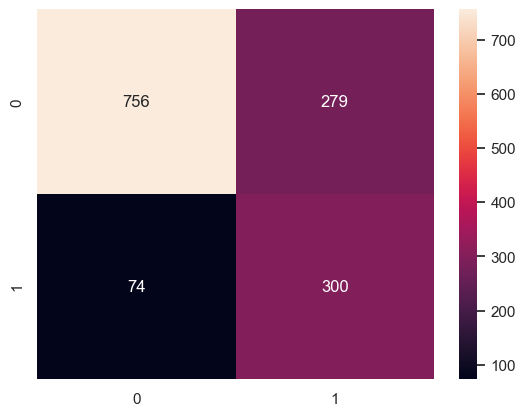

In [15]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.show()


In [16]:
joblib.dump(best_model, "model_pipeline.sav")
print("✅ Best model saved as model_pipeline.sav")

✅ Best model saved as model_pipeline.sav
